In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as Data
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim
from tqdm import trange
from tqdm.contrib import tenumerate

In [2]:
df = pd.read_csv(r'data.csv').iloc[:, 1:]
df.head()
df = df.values
DF_RANGE = 100

In [3]:
# 滑动窗口制作 8输入/1输出 的数据集
def data_process(df, window_size, predict_size):
    df = df / DF_RANGE
    data_in = []
    data_out = []
    for i in range(df.shape[0] - window_size - predict_size):
        data_in.append(df[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(df[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    data_dict = {'data_in': data_in, 'data_out': data_out}
    return data_dict

In [4]:
# 原数据范围0~100
def data_reduce(data):
    return data * DF_RANGE

In [5]:
# Hyperparameters
WINDOW_SIZE = 8
PREDICT_SIZE = 1
INPUT_SIZE = WINDOW_SIZE
HIDDEN_SIZES = 128
NUMS_LAYERS = 3
NUM_CLASSES = PREDICT_SIZE
NUM_EPOCH = 500
LEARNING_RATE = 1e-2

In [6]:
# 分割数据集
data_dict = data_process(df, WINDOW_SIZE, PREDICT_SIZE)
X_train, X_test, y_train, y_test = train_test_split(
    data_dict['data_in'],
    data_dict['data_out'],
    test_size=0.05,
    shuffle=False
)
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [7]:
# 制作Dataloader
train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)
train_loader = Data.DataLoader(dataset=train_data, batch_size=512, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class LSTM(nn.Module):
    def __init__(
            self,
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZES,
            num_layers=NUMS_LAYERS,
            num_classes=NUM_CLASSES,
            device='cpu'
    ):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[0])
        return out

In [10]:
# 测试一下
import torchkeras

model = LSTM()
torchkeras.summary(model, input_shape=(8,))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LSTM-1                                  [-1, 2, 128]              334,848
Linear-2                                     [-1, 1]                  129
Total params: 334,977
Trainable params: 334,977
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000031
Forward/backward pass size (MB): 0.001961
Params size (MB): 1.277836
Estimated Total Size (MB): 1.279827
--------------------------------------------------------------------------


'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLSTM-1                                  [-1, 2, 128]              334,848\nLinear-2                                     [-1, 1]                  129\n==========================================================================\nTotal params: 334,977\nTrainable params: 334,977\nNon-trainable params: 0\n--------------------------------------------------------------------------\nInput size (MB): 0.000031\nForward/backward pass size (MB): 0.001961\nParams size (MB): 1.277836\nEstimated Total Size (MB): 1.279827\n--------------------------------------------------------------------------'

In [11]:
model = LSTM(device=device)
model = model.to(device)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
# 看看各阶段的拟合情况
def evaluate(model, is_last=False):
    model = model.eval()
    preds = []
    reals = []

    for batch_idx, (data, targets) in enumerate(test_loader):
        data = data.to(device)
        scores = model(data)
        preds.append(scores.item())
        reals.append(targets.item())

    plt.plot(preds, 'r', label='prediction')
    if is_last:
        plt.plot(reals, 'b', label='real')

    model = model.train()

100%|██████████| 500/500 [03:05<00:00,  2.69it/s]


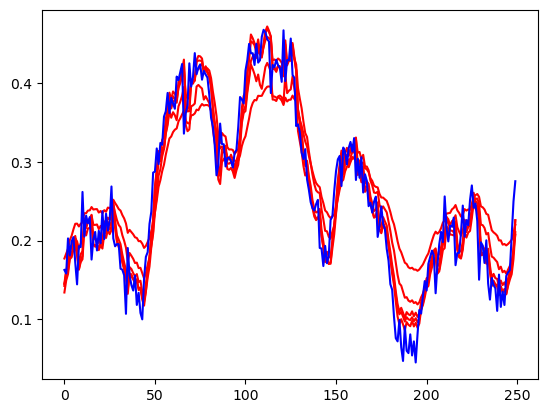

In [14]:
losses = []
for epoch in trange(NUM_EPOCH):
    train_loss = 0
    train_num = 0
    for _, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * data.size(0)
        train_num += data.size(0)

    if (epoch + 1) % 100 == 0:
        evaluate(model, is_last=((epoch + 1) == NUM_EPOCH))
    losses.append(train_loss / train_num)

In [15]:
model = model.eval()

In [16]:
preds = []
reals = []

for batch_idx, (data, targets) in tenumerate(test_loader):
    data = data.to(device)
    scores = model(data)
    preds.append(data_reduce(scores.item()))
    reals.append(data_reduce(targets.item()))

  0%|          | 0/250 [00:00<?, ?it/s]

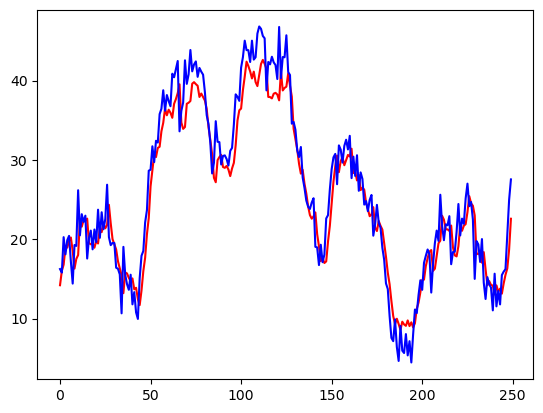

In [17]:
plt.plot(preds, 'r', label='prediction')
plt.plot(reals, 'b', label='real')

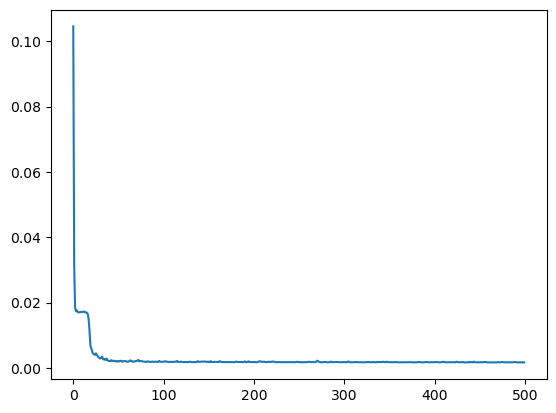

In [18]:
plt.plot(losses)

In [19]:
from utils import save_checkpoint

save_checkpoint(model, optimizer)

=> Saving checkpoint


In [20]:
from utils import load_checkpoint

load_checkpoint("checkpoint.pth.tar", model, optimizer, LEARNING_RATE)

model(torch.rand((1, 8,)).to(device))

=> Loading checkpoint


tensor([[0.6585]], device='cuda:0', grad_fn=<AddmmBackward0>)